In [ ]:
import torch
from mrpro.utils.sliding_window import sliding_window
from torch.nn import Module
from einops import rearrange
from mrpro.nn.NDModules import ConvND
class ShiftedWindowMSA(Module):
    def __init__(self, dim, channels, n_heads, window_size=7, shifted=True):
        super().__init__()
        self.channels = channels
        self.n_heads = n_heads
        self.window_size = window_size
        self.shifted = shifted
        self.to_qkv = ConvND(dim)(channels, 3*channels, 1)
        self.dim=dim
    def forward(self, x):
        if self.shifted:
            x = torch.roll(x, (-(self.window_size//2),)*self.dim,dims=tuple(range(-self.dim, 0)))
        qkv = self.to_qkv(x)   
        windowed = sliding_window(qkv, window_shape=self.window_size, stride=self.window_size, dim=range(-self.dim, 0))
        flat = windowed.flatten(0,self.dim-1).flatten(-self.dim) 
        q,k,v = rearrange(flat, 'spatial batch (qkv heads channels) window->qkv spatial batch heads window channels', heads = self.n_heads, qkv=3)
        result = torch.nn.functional.scaled_dot_product_attention(q,k,v, attn_mask=None)
        result = rearrange(result, 'spatial batch head window channels->batch (head channels) spatial window')
        result=result.unflatten(-2, windowed.shape[:self.dim]).unflatten(-1, (self.window_size,)*self.dim)
        result=result.moveaxis(list(range(-self.dim, 0)), list(range(3, 3+2*self.dim, 2)))
        result = result.reshape(x.shape)
        if self.shifted:
            result = torch.roll(result, (self.window_size//2,)*self.dim,dims=tuple(range(-self.dim, 0)))
        return result

In [97]:
m=ShiftedWindowMSA(dim=2, channels=16, n_heads=4, window_size=5, shifted=True).cuda()

In [98]:
x=torch.arange(2*16*20*30).reshape(2,16,20,30).float().cuda()

In [108]:
m(x).shape

torch.Size([2, 16, 20, 30])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

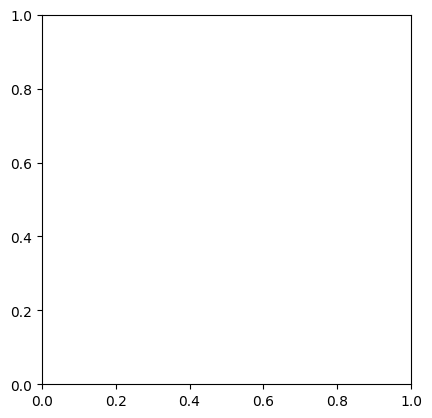

In [100]:
import matplotlib.pyplot as plt
plt.imshow(x[0,0])
plt.show()
plt.imshow(m(x)[0,0])
plt.show()